# 7 Moving Beyond Linearity

## 7.1 Polynomial Regression

Historically, the standard way to extend linear regression to settings in which the relationship between the predictors and the response is nonlinear has been to replace the standard linear model
$$ y_i = \beta_0+\beta_1 x_i+\epsilon_i $$
with a polynomial function
$$ y_i = \beta_0+\beta_1 x_i+\beta_2 x^2_i+\beta_3 x^3_i+\ldots+\beta_d x^d_i+\epsilon_i\tag{7.1} $$
This approach is known as *polynomial regression*. For large enough degree d, a polynomial regression allows us to produce an extremely non-linear curve. Generally speaking, it is unusual to use d greater than 3 or 4 because for large values of d, the polynomial curve can become overly flexible and can take on some very strange shapes. This is especially true near the boundary of the $X$ variable.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Wage.csv')
df.head(5)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [11]:
X = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
y = (df.wage > 250).map({False:0, True:1}).values

fit1 = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit)).fit()

age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
X_test1 = PolynomialFeatures(4).fit_transform(age_grid)
pred1 = fit1.predict(X_test)

<ipython-input-11-be5b61064233>:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  fit1 = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit)).fit()


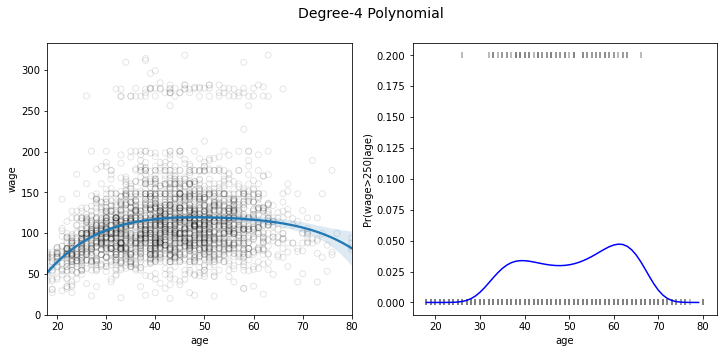

In [21]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred1, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

The left-hand panel in Figure 7.1 is a plot of wage against age for the Wage data set, which contains income and demographic information for males who reside in the central Atlantic region of the United States. We see the results of fitting a degree-4 polynomial using least squares. 

It seems like the wages in Figure 7.1 are from two distinct populations: there appears to be a high earners group earning more than \\$250,000 per annum, as well as a low earners group. We can treat wage as a binary variable by splitting it into these two groups. Logistic regression can then be used to predict this binary response, using polynomial functions of age as predictors. In other words, we fit the model
$$Pr(y_i>250|x_i)=\frac{exp(\beta_0+\beta_1 x_i +\beta_2 x^2_i +\ldots +\beta_d x^d_i)}{1+exp(\beta_0+\beta_1 x_i +\beta_2 x^2_i +\ldots +\beta_d x^d_i)}\tag{7.3} $$
The result is shown in the right-hand panel of Figure 7.1. The gray marks on the top and bottom of the panel indicate the ages of the high earners and the low earners. The solid blue curve indicates the fitted probabilities of being a high earner, as a function of age. 

## 7.2  Step Functions

Using polynomial functions of the features as predictors in a linear model imposes a *global* structure on the non-linear function of $X$. We can instead use *step functions* in order to avoid imposing such a global structure.

Here we break the range of $X$ into *bins*, and fit a different constant in each bin. This amounts to converting a continuous variable into an *ordered categorical variable*.

In greater detail, we create cutpoints $c_1, c_2, \ldots, c_K$ in the range of $X$, and then construct $K + 1$ new variables
$$
\begin{align}
C_0(X) &= I(X<c_1) \\
C_1(X) &= I(c_1\le X<c_2) \\
C_2(X) &= I(c_2\le X<c_3) \\
\vdots \\
C_{K-1}(X) &= I(c_{K-1}\le X<c_K) \\
C_K(X) &= I(c_K\le X)
\end{align}\tag{7.4}
$$
where $I(·)$ is an indicator function that returns a 1 if the condition is true, indicator and returns a 0 otherwise. These are sometimes called dummy variables. 
Notice that for any value of $X$, $C_0(X)+C_1(X)+\ldots+C_K(X)=1$, since $X$ must be in exactly one of the $K + 1$ intervals. We then use least squares to fit a linear model using $C_1(X), C_2(X),\ldots,C_K(X)$ as predictors:
$$y_i=\beta_0+\beta_1 C_1(x_i)+\beta_2 C_2(x_i)+\ldots+\beta_K C_K(x_i)+\epsilon_i \tag{7.5}$$

In [5]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [6]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


In [7]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)
df_steps_dummies.head(5)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0
4,1.0,0,0,1,0


In [15]:
fit2 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[[1]], axis=1)).fit()
fit2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [16]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))

pred2 = fit2.predict(X_test2)

fit3 = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[[1]], axis=1),
              family=sm.families.Binomial(sm.families.links.logit)).fit()
pred3 = fit3.predict(X_test2)

<ipython-input-16-ec33661e49ec>:10: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  family=sm.families.Binomial(sm.families.links.logit)).fit()


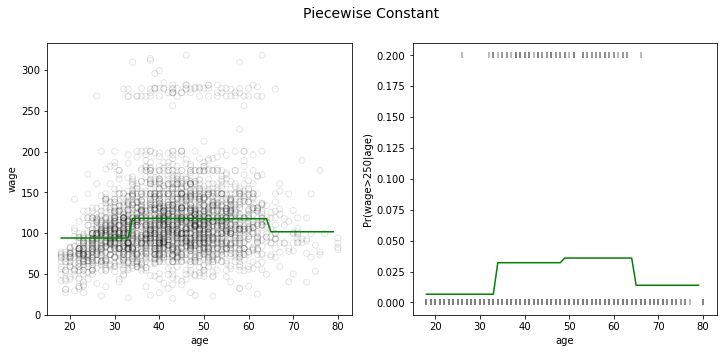

In [20]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
ax1.plot(age_grid, pred2, c='g')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='g')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

An example of fitting step functions to the Wage data from Figure 7.1 is shown in the left-hand panel of Figure 7.2. We also fit the logistic regression model
$$
Pr(y_i>250|x_i)=\frac{exp(\beta_0+\beta_1 C_1(x_i)+\ldots+\beta_KC_K(x_i))}{1+exp(\beta_0+\beta_1 C_1(x_i)+\ldots+\beta_KC_K(x_i))}\tag{7.6}
$$
in order to predict the probability that an individual is a high earner on the basis of age. The right-hand panel of Figure 7.2 displays the fitted posterior probabilities obtained using this approach.

Unfortunately, unless there are natural breakpoints in the predictors, piecewise-constant functions can miss the action. For example, in the left-hand panel of Figure 7.2, the first bin clearly misses the increasing trend of wage with age.

## 7.3 Basis Functions

Polynomial and piecewise-constant regression models are in fact special cases of a *basis function* approach. The idea is to have at hand a family of functions or transformations that can be applied to a variable $X$: $b_1(X), b_2(X), \ldots, b_K(X)$.  Instead of fitting a linear model in $X$, we fit the
model
$$
y_i = \beta_0+\beta_1 b_1(x_i)+\beta_2 b_2(x_i)+\beta_3 b_3(x_i)+\ldots+\beta_K b_K(x_i)+\epsilon_i\tag{7.7}
$$

Note that the basis functions $b_1(·), b_2(·),\ldots,b_K(·)$ are fixed and known. For polynomial
regression, the basis functions are $b_j(x_i)=x^j_i$, and for piecewise constant functions they are $b_j(x_i)=I(c_j\le x_j<c_{j+1})$. We can think of (7.7) as a standard linear model with predictors $b_1(x_i), b_2(x_i),\ldots,b_K(x_i)$. Hence, we can use least squares to estimate the unknown regression coefficients in (7.7). Importantly, this means that all of the inference tools for linear models that are discussed in Chapter 3, such as standard errors for the
coefficient estimates and F-statistics for the model’s overall significance, are available in this setting.

## 7.4 Regression Splines

### 7.4.1 Piecewise Polynomials
Instead of fitting a high-degree polynomial over the entire range of $X$, *piecewise polynomial regression* involves fitting separate low-degree polynomials over different regions of $X$. For example, a piecewise cubic polynomial works by fitting a cubic regression model of the form
$$
y_i = \beta_0+\beta_1 x_i +\beta_2 x^2_i +\beta_3 x^3_i +\epsilon_i \tag{7.8}
$$
where the coefficients $\beta_0, \beta_1, \beta_2,\beta_3 $differ in different parts of the range of $X$. The points where the coefficients change are called *knots*.

For example, a piecewise cubic with no knots is just a standard cubic polynomial, as in (7.1) with $d = 3$. A piecewise cubic polynomial with a single knot at a point $c$ takes the form
$$
y_i = \begin{cases}
\beta_{01} + \beta_{11} x_i +\beta_{21} x^2_i +\beta_{31} x^3_i +\epsilon_i,\; if x_i<c, \\
\beta_{02} + \beta_{12} x_i +\beta_{22} x^2_i +\beta_{32} x^3_i +\epsilon_i,\; if x_i\ge c.
\end{cases}
$$

The top left panel of Figure 7.3 shows a piecewise cubic polynomial fit to a subset of the Wage data, with a single knot at age=50. We immediately see a problem: the function is discontinuous and looks ridiculous! Since each polynomial has four parameters, we are using a total of eight *degrees of freedom* in fitting this piecewise polynomial model.
![7.3](img/7.3.png)

### 7.4.2 Constraints and Splines
The top left panel of Figure 7.3 looks wrong because the fitted curve is just too flexible. To remedy this problem, we can fit a piecewise polynomial under the constraint that the fitted curve must be continuous. The top right plot in Figure 7.3 shows the resulting fit. This looks better than the top left plot, but the V-shaped join looks unnatural.

In the lower left plot, we have added two additional constraints: now both the first and second derivatives of the piecewise polynomials are continuous at age=50. In other words, we are requiring that the piecewise polynomial
be not only continuous when age=50, but also very smooth.
Each constraint that we impose on the piecewise cubic polynomials effectively frees up one degree of freedom, by reducing the complexity of the resulting piecewise polynomial fit. So in the top left plot, we are using eight degrees of freedom, but in the bottom left plot we imposed three constraints (continuity, continuity of the first derivative, and continuity of the second derivative) and so are left with five degrees of freedom. The curve in the bottom left plot is called a *cubic spline*. In general, a cubic spline with $K$ knots uses a total of $4 + K$ degrees of freedom.

In Figure 7.3, the lower right plot is a *linear spline*, which is continuous at age=50. The general definition of a degree-d spline is that it is a piecewise degree-d polynomial, with continuity in derivatives up to degree $d − 1$ at each knot. 

### 7.4.3 The Spline Basis Representation
The regression splines that we just saw in the previous section may have seemed somewhat complex: how can we fit a piecewise degree-d polynomial under the constraint that it (and possibly its first $d − 1$ derivatives) be continuous? It turns out that we can use the basis model (7.7) to represent
a regression spline. A cubic spline with $K$ knots can be modeled as
$$
y_i = \beta_0 + \beta_1b_1(x_i)+\beta_2b_2(x_i)+\cdots+\beta_{K+3}b_{K+3}(x_i)+\epsilon_i\tag{7.9}
$$

Just as there were several ways to represent polynomials, there are also many equivalent ways to represent cubic splines using different choices of basis functions in (7.9). The most direct way to represent a cubic spline using (7.9) is to start off with a basis for a cubic polynomial—namely, $x, x^2. x^3$—and then add one *truncated power basis* function per knot. A truncated power basis function is defined as
$$
h(x,\xi)=(x-\xi)^3_+ = \begin{cases}
(x-\xi)^3  \; if x>\xi\\
0  \; otherwise,
\end{cases}\tag{7.10}
$$

where $\xi$ is the knot. One can show that adding a term of the form $\beta_4h(x, \xi)$ to the model (7.8) for a cubic polynomial will lead to a discontinuity in only the third derivative at $\xi$; the function will remain continuous, with continuous first and second derivatives, at each of the knots.


Unfortunately, splines can have high variance at the outer range of the predictors—that is, when $X$ takes on either a very small or very large value. Figure 7.4 shows a fit to the Wage data with three knots. We see that the confidence bands in the boundary region appear fairly wild. A *natural spline* is a regression spline with additional boundary constraints: the function is required to be linear at the boundary (in the region where $X$ is smaller than the smallest knot, or larger than the largest knot). This additional constraint means that natural splines generally produce more stable estimates at the boundaries. In Figure 7.4, a natural cubic spline is also displayed as a red line. Note that the corresponding confidence intervals are narrower.
![7.4](img/7.4.png)

### 7.4.4 Choosing the Number and Locations of the Knots
When we fit a spline, where should we place the knots? The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. Hence, one
option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. While this option can work well, in practice it is common to place knots in a uniform fashion. One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

In [58]:
# Specifying 3 knots
transformed_3knots = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                         {"df.age": df.age}, return_type='dataframe')
spln_3knots = sm.GLM(df.wage, transformed_3knots).fit()
pred_3knots = spln_3knots.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                                          {"age_grid": age_grid}, return_type='dataframe'))

In [31]:
# Specifying 4 degrees of freedom
transformed_deg4 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit4 = sm.GLM(df.wage, transformed_deg4).fit()
pred4 = fit4.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

fit5 = sm.GLM(y, transformed_deg4, family=sm.families.Binomial(sm.families.links.logit)).fit()
pred5 = fit5.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

<ipython-input-31-18b759d1c54f>:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  fit5 = sm.GLM(y, transformed_deg4, family=sm.families.Binomial(sm.families.links.logit)).fit()


(0.0, 350.0)

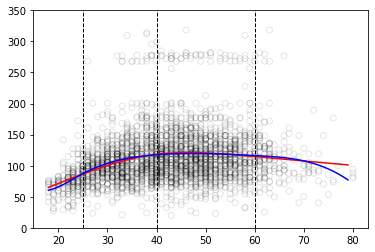

In [60]:
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred4, color='r')
plt.plot(age_grid, pred_3knots, color='b')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=1, colors='k') for i in [25,40,60]]
plt.ylim(0,350)

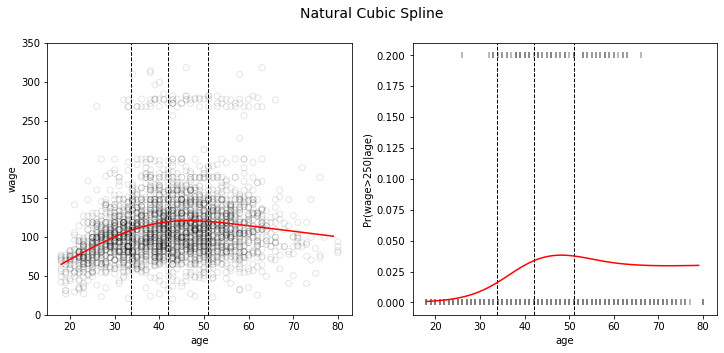

In [36]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Natural Cubic Spline', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
ax1.plot(age_grid, pred4, color='r')
[ax1.vlines(i , 0, 350, linestyles='dashed', lw=1, colors='k') for i in [33.75,42,51]]

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(0,350)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred5, color='r')
[ax2.vlines(i , -0.01, 0.21, linestyles='dashed', lw=1, colors='k') for i in [33.75,42,51]]

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

Figure 7.5 shows an example on the Wage data. As in Figure 7.4, we have fit a natural cubic spline with three knots, except this time the knot locations were chosen automatically as the 25th, 50th, and 75th percentiles of age. This was specified by requesting four degrees of freedom. The argument by which four degrees of freedom leads to three interior knots is somewhat technical.

How many knots should we use, or equivalently how many degrees of freedom should our spline contain? One option is to try out different numbers of knots and see which produces the best looking curve. A somewhat
more objective approach is to use cross-validation, as discussed in Chapters 5 and 6. With this method, we remove a portion of the data (say 10%),fit a spline with a certain number of knots to the remaining data, and then use the spline to make predictions for the held-out portion. We repeat this process multiple times until each observation has been left out once, and then compute the overall cross-validated $RSS$. This procedure can be repeated for different numbers of knots $K$. Then the value of $K$ giving the smallest $RSS$ is chosen.
![7.6](img/7.6.png)

<Figure size 864x432 with 0 Axes>

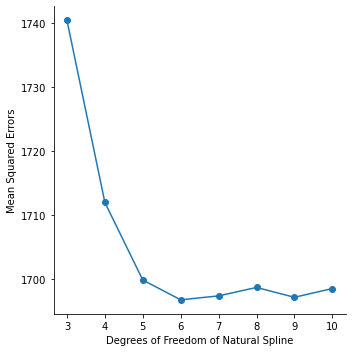

In [53]:
Degrees = np.arange(3,11)
errors = []
for i in Degrees:
    fun = 'cr(df.age, df='+str(i)+')'
    X = dmatrix(fun, {"df.age": df.age}, return_type='dataframe')
    y = df.wage
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 0)
    
    spln = sm.GLM(y_train, X_train).fit()
    errors.append(mean_squared_error(y_test,spln.predict(X_test)))
temp = pd.DataFrame({"Degrees of Freedom of Natural Spline":Degrees,'Mean Squared Errors':errors})
plt.figure(figsize = (12,6))
g = sns.FacetGrid(data = temp,size=5)
g.map(plt.scatter, 'Degrees of Freedom of Natural Spline' , 'Mean Squared Errors')
g.map(plt.plot, 'Degrees of Freedom of Natural Spline' , 'Mean Squared Errors')

### 7.4.5 Comparison to Polynomial Regression
Regression splines often give superior results to polynomial regression. This is because unlike polynomials, which must use a high degree to produce flexible fits, splines introduce flexibility by increasing the number of knots but keeping the degree
fixed.

Figure 7.7 compares a natural cubic spline with 15 degrees of freedom to a degree-15 polynomial on the Wage data set. The extra flexibility in the polynomial produces undesirable results at the boundaries, while
the natural cubic spline still provides a reasonable fit to the data.

(0.0, 350.0)

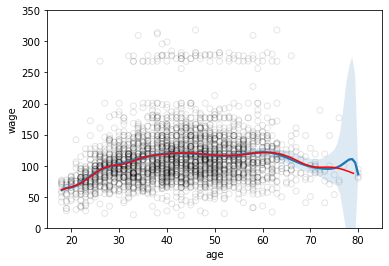

In [41]:
transformed_deg15 = dmatrix("cr(df.age, df=15)", {"df.age": df.age}, return_type='dataframe')
fit6 = sm.GLM(df.wage, transformed_deg15).fit()
pred6 = fit6.predict(dmatrix("cr(age_grid, df=15)", {"age_grid": age_grid}, return_type='dataframe'))

import warnings
warnings.filterwarnings('ignore')
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
sns.regplot(df.age, df.wage, order = 15, scatter=False)
plt.plot(age_grid, pred6, color='r', label='Natural spline df=15')
plt.xlim(15,85)
plt.ylim(0,350)

## 7.8 Lab: Non-linear Modeling
### 7.8.1 Polynomial Regression and Step Functions

In [43]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

In [44]:
fit = sm.GLS(df.wage, X4).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [45]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = fit.predict(X_test)

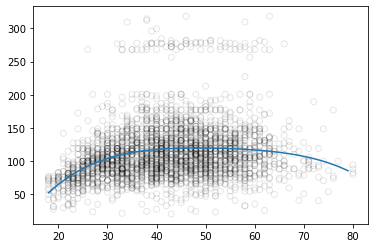

In [46]:
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred)

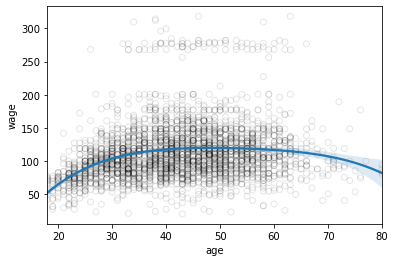

In [48]:
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
sns.regplot(df.age, df.wage, order = 4, scatter=False)

In [49]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [50]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)

df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])
df_steps_dummies = sm.add_constant(df_steps_dummies)

fit = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[[1]], axis=1)).fit()
fit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416
